In [1]:
% matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d as mp3d
import math
import os
from io import BytesIO
from scipy.integrate import simps
from scipy.signal import correlate
from scipy.signal import fftconvolve
import scipy.signal as ss
from scipy.ndimage.filters import gaussian_filter 
import random

In [152]:
def thresh_sample(v):
    m,s = v.mean(),v.std().apply(lambda x:.23*math.sqrt(x))
    tm,tM = m-s,m+s
    trunc_m = v[ v.apply(lambda x: x>tM,axis=1).sum(axis=1)!= 0]
    trunc_M = v[ v.apply(lambda x: x<tm,axis=1).sum(axis=1)!= 0]
    m_ind = min(trunc_m.index[0],trunc_M.index[0])
    M_ind = max(trunc_m.index[-1],trunc_M.index[-1])
    return v.ix[m_ind:M_ind,:]


def normalize(v):
        v = v.apply(lambda x:gaussian_filter(x,sigma=4),axis=0)
        m,s = v.mean(),v.std()
        v = v.apply(lambda x:(x-m[x.name])/s[x.name],axis=0)
        zeros = pd.DataFrame(np.zeros([512-len(v),3]),columns=['x','y','z'])
        v = v.append( zeros, ignore_index=True )
        #v = v.reindex(range(512),fill_value=0)
        return v
       
def convolve(s1,s2):
    df = pd.DataFrame()
    for x in s1.columns:
        df[x] = np.fft.ifft(np.fft.fft(s1[x])*np.fft.fft(s2[x])).real
        #df[x] = correlate(s1[x],s2[x])
        #df[x] = fftconvolve(s1[x],s2[x])
    return df


# load / preprocess signal

def load_gestures(L,preprocess=True):
    D = dict()
    for f in L:
        with open(f) as fh:
            s = ''.join([ x for x in fh if (x[0]!='#' and x[0]!='\n')])
            D[f] = pd.read_csv(BytesIO(s),sep=' ',names=['x','y','z','v'],usecols=['x','y','z'])
            if preprocess:
                D[f] = thresh_sample(D[f]).reset_index(drop=True)
            D[f] = normalize(D[f])
    return D

def create_streaming_gesture(D,length=10000):
    outDict = {'ans':[]}
    df = pd.DataFrame(columns=['x','y','z'])
    while len(df) < length:
        m = random.randint(0,200)
        if m < 100:
            k = D.keys()[random.randint(0,len(D)-1)]
            z = D[k]
            outDict['ans'].append( (len(df),k) )
        else:
            z = pd.DataFrame(np.zeros([m,3]),columns=['x','y','z'])
        df = pd.concat([df,z],axis=0)
    outDict['data'] = df.iloc[:length,:].reset_index(drop=True)
    return outDict

In [3]:
def plot_gestures(D):
    m = len(D)
    nrows = m/4+1 #(m+1)/4+1
    fig, axes = plt.subplots(nrows=nrows, ncols=4,figsize=(17,4*nrows))
    if nrows == 1:
        for i,(k,v) in enumerate(sorted(D.items())):
            v.plot(title=k,ax=axes[i],xlim=(0,512),sharey=True)
    else:
        for i,(k,v) in enumerate(sorted(D.items())):
            v.plot(title=k,ax=axes[i/4,i%4],xlim=(0,512),sharey=True)
        

In [4]:
def convolve_stream(stream):
    D = dict()
    for gesture,v in trainingD.items():
        D[gesture] = []
        for k in range(len(stream)-512):
            if k % 50 == 0:
                window = stream[k:k+512]
                a = convolve(window,v).max().max()
                D[gesture].append(a)
            else:
                D[gesture].append(a)
    return D


In [176]:
df = pd.read_csv('./training/five.csv',header=None,names=['x','y','z'])

In [177]:
L = [ df.ix[k*100:(k+1)*100] for k in range(3,7) ]

In [178]:
normedL = [ normalize(thresh_sample(x)) for x in L ] 

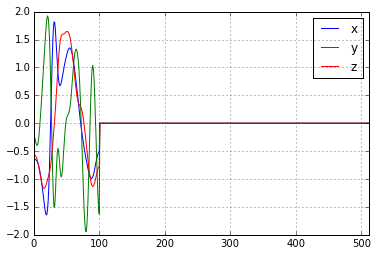

In [179]:
normalize(L[1]).plot()

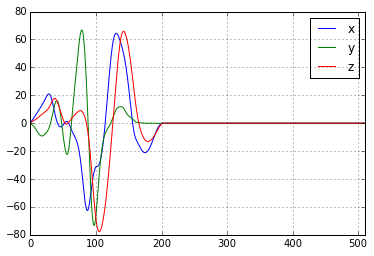

In [180]:
convolve(normedL[0],normedL[3]).plot()

In [37]:
df = thresh_sample(df.ix[400:500])

In [38]:
df = normalize(df)

In [39]:
#df.to_csv('./training/hifive__2.txt',header=False,index=False)

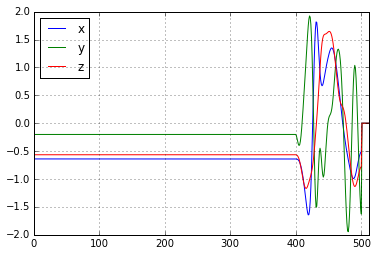

In [40]:
df.plot()

In [42]:
convolve(df,df).max().max()

239.67008965719774

Object `pd.append` not found.


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])